## Design a smooth path for a car

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from scipy.ndimage import gaussian_filter1d

### Import and Clean Data

In [199]:
df = pd.read_csv('BrandsHatchLayout.csv')
df.head()

,x,y,side
0,NaN,NaN,left
1,15.378594,25.160551,left
2,38.563538,34.852362,left
3,61.494312,44.538522,left
4,84.168212,56.112361,left


In [200]:
# remove rows with NaN values
df_cleaned = df.dropna()
df_cleaned.head()

,x,y,side
1,15.378594,25.160551,left
2,38.563538,34.852362,left
3,61.494312,44.538522,left
4,84.168212,56.112361,left
5,109.091232,63.940941,left


In [201]:
# separate cones into left and right
l_cones = df_cleaned[df_cleaned['side'] == 'left']
r_cones = df_cleaned[df_cleaned['side'] == 'right']

print(l_cones.tail())
print(r_cones.tail())

              x          y  side
152 -104.155982 -27.052745  left
153  -80.963958 -17.136628  left
154  -57.715627  -7.490608  left
155  -34.765427   2.039457  left
156  -12.420103  12.695313  left
             x          y   side
309 -90.550419 -56.939580  right
310 -67.933103 -46.895694  right
311 -45.005572 -37.335930  right
312 -21.712926 -27.601979  right
313   0.874583 -16.212064  right


### Create midpoints and Design a path

In [202]:
midpoints = []

# Find the smallest distance between left and right cones
for i in range(len(l_cones)):
    l_cone = l_cones.iloc[i] 
    min_distance = 99999  
    neigh_r_cone = None  
    
    for j in range(len(r_cones)):
        r_cone = r_cones.iloc[j]  
        distance = np.sqrt((r_cone['x'] - l_cone['x'])**2 + (r_cone['y'] - l_cone['y'])**2)
        
        if distance < min_distance:
            min_distance = distance
            neigh_r_cone = r_cone

    # Calculate a midpoint and add it to the list
    midpoint = [(l_cone['x'] + neigh_r_cone['x']) / 2, (l_cone['y'] + neigh_r_cone['y']) / 2] 
    midpoints.append(midpoint)
midpoints.append([19, 9])  # removed the curve break, couldn't find another way
midpoints = np.array(midpoints)

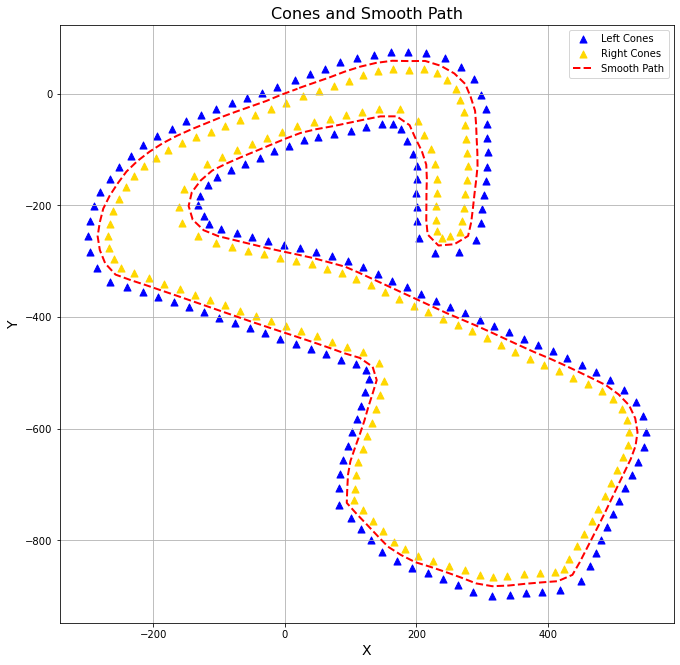

In [208]:
# Plot cones and the path
plt.figure(figsize=(11, 11))
plt.scatter(l_cones['x'], l_cones['y'], color='blue', marker='^', label='Left Cones', s=50)
plt.scatter(r_cones['x'], r_cones['y'], color='gold', marker='^', label='Right Cones', s=50)
plt.plot(midpoints[:, 0], midpoints[:, 1], color='red', label='Smooth Path', linestyle='--', linewidth=2)
plt.title('Cones and Smooth Path', fontsize=16)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)
plt.legend()
plt.grid()
plt.show()

### Optimize the path for minimal curvature

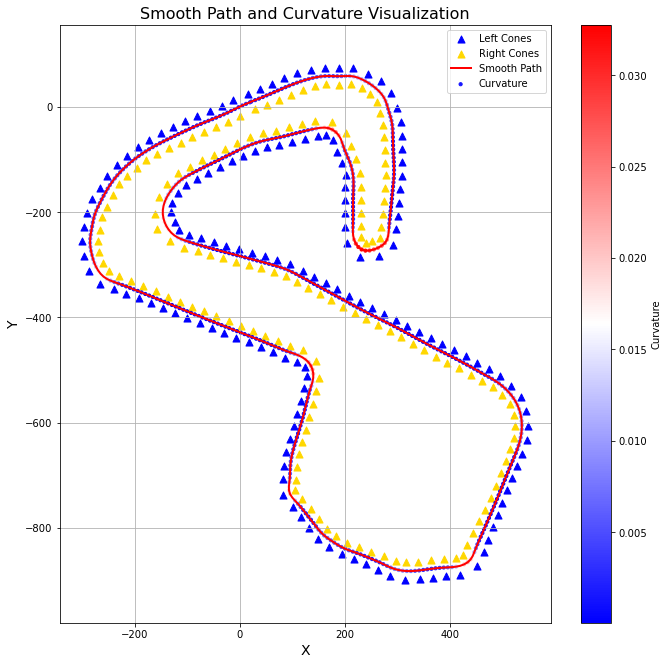

In [241]:
# Function for calculating the radius of curvature
def calc_curv(x, y):
    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5
    curvature = np.nan_to_num(curvature, nan=0.0, posinf=0.0, neginf=0.0)  # work with NaN values
    return curvature

# Visualization of the central trajectory taking into account safety zones
def plot_path_with_curv(midpoints, smooth_path, curvature):
    plt.figure(figsize=(11, 11))
    plt.scatter(l_cones['x'], l_cones['y'], color='blue', marker='^', label='Left Cones', s=50)
    plt.scatter(r_cones['x'], r_cones['y'], color='gold', marker='^', label='Right Cones', s=50)
    plt.plot(smooth_path[0], smooth_path[1], color='red', linewidth=2, label='Smooth Path')
    
    # Visualize curvature as color gradation
    plt.scatter(smooth_path[0], smooth_path[1], c=curvature, cmap='bwr', label='Curvature', s=10)
    plt.xlabel('X', fontsize=14)
    plt.ylabel('Y', fontsize=14)
    plt.title('Smooth Path and Curvature Visualization', fontsize=16)
    plt.colorbar(label='Curvature')
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.show()

# Calculate and visualize
def update_plot(smoothing_factor):
    # Spline by midpoints with specified smoothing
    tck, u = splprep(midpoints.T, s=smoothing_factor)
    smooth_path = splev(np.linspace(0, 1, 500), tck)
    
    # Calculate the curvature
    curvature = calc_curv(smooth_path[0], smooth_path[1])

    # Visualize the path and curvature
    # *Curvature helps identify sharp turns and optimize the path for smoother, safer, and faster navigation
    plot_path_with_curv(midpoints, smooth_path, gaussian_filter1d(curvature, sigma=2))

# Call the function with the initial smoothing value
update_plot(3.0)